In [1]:
import pandas as pd
from pennylane import numpy as np
import math
import pennylane as qml
import random
import tensorflow as tf
import time

In [2]:
# Read data
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop(['Unnamed: 0'], axis=1)
# df=df[:100]
# df=df.drop(columns=['ARIMA'])

In [3]:
target = "Close"
features = list(df.columns.difference(["Close","ARIMA"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

In [4]:
len(features)

24

## Data Processing

In [5]:
random.seed(42)
# close_min=min(df['Close'].values)
# close_max=max(df['Close'].values)
# normalized_df=(df-df.min())/(df.max()-df.min())

In [6]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [7]:
normalized_df=df

In [8]:
normalized_df.head()

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
0,-2.117565,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.243124,-2.117565,1.500541,-9.214615,...,1.529613,1.234563,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.730166,-2.117565
1,-2.312586,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.482745,-2.312586,1.423609,-9.214615,...,1.462366,1.411190,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.160281,-2.312586
2,-2.604116,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.851864,-2.604116,1.423609,-9.214615,...,1.462366,1.411190,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.028158,-2.604116
3,-2.520689,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.744853,-2.520689,1.445590,-9.214615,...,1.395119,1.397119,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.619960,-2.520689
4,-2.271642,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.431965,-2.271642,1.559810,-9.214615,...,1.260624,1.190869,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.212893,-2.271642


In [9]:
df=normalized_df.copy()

In [10]:
# Data for regression model
sequence_length_reg = window_reg =30 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,5):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(616, 30, 24) (616, 30)


In [11]:
indices = tf.range(start=0, limit=tf.shape(X_reg)[0])
shuffled_indices = tf.random.shuffle(indices)
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [12]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (554, 30, 24) and (554, 30)
Shape os test is (62, 30, 24) and (62, 30)


In [13]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(16620, 24)
(16620,)


In [14]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(1860, 24)
(1860,)


In [15]:
# Prepare check data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg+1:len(df)- window_reg+1]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

In [16]:
# Python Program to find the factors of a number

# This function computes the factor of the argument passed
def print_factors(x):
    print("The factors of",x,"are:")
    for i in range(1, x + 1):
        if x % i == 0:
            print(i)

num = 16620

print_factors(num)

The factors of 16620 are:
1
2
3
4
5
6
10
12
15
20
30
60
277
554
831
1108
1385
1662
2770
3324
4155
5540
8310
16620


# QNN

In [31]:
nqubits = 8
device = qml.device('default.qubit', wires=nqubits)
# Define QNode
@qml.qnode(device)
def quantum_circuit(inputs, params):
    for p1,p2,p3,p4,p5,p6,p7,p8 in zip(params[:4],params[4:8],params[8:12],params[12:16],params[16:20],params[20:24]
                                ,params[24:28],params[28:32]):
        qml.Rot(*inputs[:3], wires=0)
        qml.Rot(*inputs[3:6], wires=1)
        qml.Rot(*inputs[6:9], wires=2)
        qml.Rot(*inputs[9:12], wires=3)
        qml.Rot(*inputs[12:15], wires=4)
        qml.Rot(*inputs[15:18], wires=5)
        qml.Rot(*inputs[18:21], wires=6)
        qml.Rot(*inputs[21:24], wires=7)
        qml.Rot(*p1, wires=0)
        qml.Rot(*p2, wires=1)
        qml.Rot(*p3, wires=2)
        qml.Rot(*p4, wires=3)
        qml.Rot(*p5, wires=4)
        qml.Rot(*p6, wires=5)
        qml.Rot(*p7, wires=6)
        qml.Rot(*p8, wires=7)
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[3, 4]) 
        qml.CNOT(wires=[4, 5])
        qml.CNOT(wires=[5, 6]) 
        qml.CNOT(wires=[6, 7])
        qml.CNOT(wires=[7, 0]) 
    return [qml.expval(qml.PauliZ(0))]

In [32]:
def loss_func(params):
    predictions = [np.add(params[32][2],np.multiply(params[32][1],np.add(params[32][0],quantum_circuit(x, params)))) for x in X_train_reg_]
    predictions=np.array([i for i in predictions])
    total_losses=np.mean((y_train_reg_ - predictions) ** 2)
    return total_losses

In [33]:
def cost_fn(params,**kwargs):
    z=kwargs['batch']
    predictions = [np.add(params[32][2],np.multiply(params[32][1],np.add(params[32][0],quantum_circuit(x, params)))) for x in X_train_reg_[z*batch_size: (z+1)*batch_size]]
    predictions=np.array([i for i in predictions])
    cost=np.mean((y_train_reg_[z*batch_size: (z+1)*batch_size] - predictions) ** 2)
    return cost

In [34]:
opt = qml.AdamOptimizer(stepsize=0.01)

params=np.random.normal(-0.05, 0.05, size=(33, 3),requires_grad = True)

In [35]:
len(params)

33

In [36]:
batch_size=32 # Batch size
batch_list=list(range(0,int(len(X_train_reg_)/batch_size)))

In [ ]:
for i in range (10):
    for j in batch_list:
        # Run for batch
#         start=time.time()
        params, prev_cost = opt.step_and_cost(cost_fn,params,batch=j)
        print(f'Step = {i} Cost = {prev_cost}')
#         end=time.time()
#         print('Execution time for optimizer',end-start)
    # Loss for whole data
#     start=time.time()
    if i%5==0:
        print(f'Step = {i} Cost = {loss_func(params)}')
#     end=time.time()
#     print('Execution time for loss check',end-start)

Step = 0 Cost = 0.42191312088456356
Step = 0 Cost = 1.8011905455179458
Step = 0 Cost = 1.2039664517858069
Step = 0 Cost = 0.18718992801020895
Step = 0 Cost = 0.7820842228374244
Step = 0 Cost = 0.8643993783020931
Step = 0 Cost = 0.6040517515003556
Step = 0 Cost = 0.461417949426328
Step = 0 Cost = 0.5922629478048542
Step = 0 Cost = 0.4382242971687892
Step = 0 Cost = 0.4900256326399261
Step = 0 Cost = 2.3341351698393025
Step = 0 Cost = 0.45000937010035297
Step = 0 Cost = 0.3139636363296334
Step = 0 Cost = 2.7826234997788397
Step = 0 Cost = 1.0345769836593561
Step = 0 Cost = 0.3095640672814949
Step = 0 Cost = 0.9983373223042599
Step = 0 Cost = 1.7904786747226127
Step = 0 Cost = 1.1434404948558743
Step = 0 Cost = 3.581534937532002
Step = 0 Cost = 1.9399398006112158
Step = 0 Cost = 1.1995001994779866
Step = 0 Cost = 0.9299503256473364
Step = 0 Cost = 0.8731567282695141
Step = 0 Cost = 0.7375738160052288
Step = 0 Cost = 1.5173124283775787
Step = 0 Cost = 1.1724606212499937
Step = 0 Cost = 0.2

In [ ]:
loss_func(params)

In [24]:
params

tensor([[ 1.89267835e-02,  1.74220058e-02, -3.21492846e-01],
        [-2.43818090e-01, -1.97422024e-01,  1.06006553e-01],
        [-8.12128039e-01,  2.56839005e-01,  1.67327957e-01],
        [-8.72185332e-01, -3.16499590e-01, -7.74463587e-02],
        [-2.89188047e-02, -1.04996623e+00,  6.22712517e-01],
        [-4.17361332e-01, -4.27425495e-01,  4.16953613e-01],
        [-2.81930343e-01, -1.18152397e+00,  1.32430538e-01],
        [-5.96761712e-01, -6.97219345e-01, -1.02922375e-01],
        [-5.28877380e-01, -5.70161280e-01, -4.11007194e-01],
        [-3.91913482e-01, -8.61740058e-02, -7.51289247e-01],
        [-2.39615047e-01,  7.06476912e-01, -5.71392888e-01],
        [ 1.58993226e+00,  3.64343965e-01,  1.74912081e-02],
        [ 2.71130059e-01,  3.47109050e-01, -6.88070090e-01],
        [-1.62755786e-01, -2.79880968e-01, -8.03087820e-02],
        [ 5.86358725e-01,  6.06746875e-01,  8.13239917e-01],
        [-1.69835482e-01,  9.31339843e-01, -6.01874625e-02],
        [ 5.71342207e-01

In [27]:
# Make pred for check data
def pred_(X,params):
    predict_ = [np.add(np.sum(np.multiply(np.hstack((params[32],params[33],params[34][:-1])), 
                                             quantum_circuit(x, params))),params[34][-1]) for x in X]
    return predict_

In [29]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [30]:
# Predict the price
y_test_pred_ann = pred_(X_test_reg_,params) 

In [32]:
y_test_pred_ann_=[]
for i in y_test_pred_ann:
    y_test_pred_ann_.append(i.numpy())

In [34]:
mae_test_ann = mae_metric(y_test_reg_* target_stdev + target_mean, np.array(y_test_pred_ann_)* target_stdev + target_mean)
print('MAE test: ',mae_test_ann)
rmse_test_ann = rmse_metric(y_test_reg_* target_stdev + target_mean, np.array(y_test_pred_ann_)* target_stdev + target_mean)
print('RMSE test: ',rmse_test_ann)

MAE test:  332.10719631113346
RMSE test:  440.3904255684498


In [26]:
# Predict the model 
y_check_pred_ann = pred_(X_check_reg,params) 

In [27]:
y_check_pred_ann_=[]
for i in y_check_pred_ann:
    y_check_pred_ann_.append(i[0].numpy())

In [28]:
mae_check_ann = mae_metric((y_check_reg*(close_max - close_min)) + close_min, np.array(y_check_pred_ann_)*(close_max - close_min)+ close_min)
print('MAE test: ',mae_check_ann)
rmse_check_ann = rmse_metric((y_check_reg*(close_max - close_min)) + close_min, np.array(y_check_pred_ann_)*(close_max - close_min)+ close_min)
print('RMSE test: ',rmse_check_ann)

MAE test:  327.87327345183695
RMSE test:  335.44317287353965


In [29]:
import matplotlib.pyplot as plt

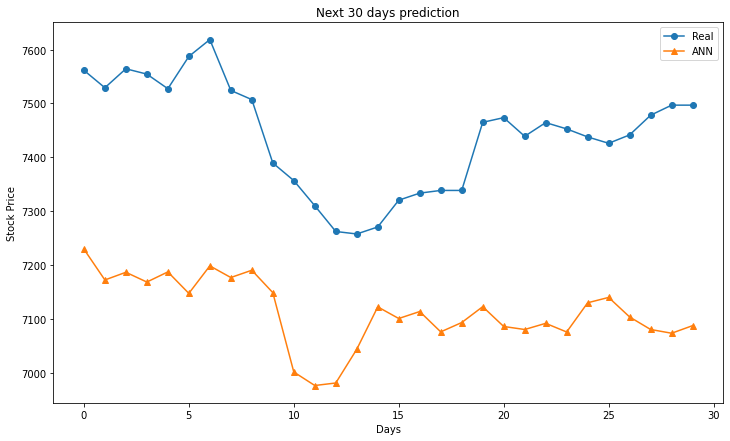

In [30]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_reg *(close_max - close_min) + close_min, label = "Real",marker='o')
plt.plot(np.array(y_check_pred_ann_)*(close_max - close_min)+ close_min, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title('Next '+str(window_reg)+' days prediction')
plt.legend()
plt.show()